# This test doesn't use any labels at all, but evaluates models on their user assessed false positive and false negative rates after predictions are made. 
1. Make predictions on a recording
2. look at the model predictions sorted by confidence. 
3. Count the false positives and false negatives within these predictions. 

In [1]:
# imports
from pathlib import Path
import sys
import shutil
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
model_save_path = BASE_PATH / 'models'
import pandas as pd
import numpy as np
import opensoundscape as opso
from opensoundscape import audio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ipywidgets import interact
import glob
from src.utils import top_down_listen

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# load the test data
data_path = Path.cwd().parent.parent / "data"
test_df = pd.read_pickle(data_path / "interim" / "test_set" / "test_set.pkl")
ext_df = pd.read_csv(data_path / "raw" / "test_set" / "SingleSpecies_all.csv", low_memory=False)

In [5]:
# Load the target species examples from the external test set
ext_df = pd.read_csv(data_path / "raw" / "test_set" / "SingleSpecies_all.csv", low_memory=False)
# filter out all the other species
osfls = ext_df.loc[ext_df.species_code == "OSFL"]
# filter out the target species calls and keep the songs. 
osfls = osfls.loc[osfls.vocalization == "Song"]


In [6]:
recording_save_path = data_path / "raw" / "recordings" / "OSFL"
external_test_set_recordings = data_path / "processed" / "external_test_set_recordings"

def get_file_extension(url):
    file_type = url.split('.')[-1]
    return file_type
def make_filename(df):
    
    return f"recording-{df.recording_id}.{df.file_type}"

osfls['file_type'] = osfls['recording_url'].apply(get_file_extension)
osfls['filename'] = osfls.apply(make_filename, axis=1)
external_test_set_filenames = osfls.filename.unique()
len(external_test_set_filenames), external_test_set_filenames

(39,
 array(['recording-255472.flac', 'recording-255412.mp3',
        'recording-255913.flac', 'recording-255938.flac',
        'recording-255940.flac', 'recording-255949.flac',
        'recording-255967.flac', 'recording-255980.flac',
        'recording-255420.mp3', 'recording-255419.mp3',
        'recording-255421.mp3', 'recording-255431.mp3',
        'recording-255432.mp3', 'recording-255433.mp3',
        'recording-255449.mp3', 'recording-255456.mp3',
        'recording-255454.mp3', 'recording-255457.mp3',
        'recording-255461.mp3', 'recording-255465.mp3',
        'recording-255539.flac', 'recording-255544.flac',
        'recording-255497.mp3', 'recording-255513.mp3',
        'recording-255518.mp3', 'recording-255526.mp3',
        'recording-255623.flac', 'recording-255624.flac',
        'recording-255625.flac', 'recording-255580.mp3',
        'recording-255581.mp3', 'recording-255582.mp3',
        'recording-255649.flac', 'recording-255607.mp3',
        'recording-255665.mp3'

In [9]:
# if the recordings are not already saved, save them to the processed folder
if not external_test_set_recordings.exists():
    external_test_set_recordings.mkdir(parents=True, exist_ok=True)
    for file in external_test_set_filenames:
        source = recording_save_path / file
        destination = external_test_set_recordings / file
        shutil.copy(source, destination)
        print(f"copied {source} to {destination}")
else:
    print(f"Recordings already saved to {external_test_set_recordings}")
        

Recordings already saved to /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/external_test_set_recordings


# The OSFL model was run using the predict.py program in the OSFL project root.

# Processing times

39 recordings, 782.2mb <br>
Took 11 min 31 seconds to process with OSFL recognizer on 1 CPU core for preprocessing and used the GPU for inference on mac<br>
Another time it took 8 minutes<br>
took 17 mins on windows machine with 1 cpu core for preprocessing, and this decreased to 13 mins with 8 cores



# Load the OSFL model predictions

In [10]:
osfl_model_predictions = pd.read_csv(BASE_PATH / "OSFL-scores.csv").sort_values(by="target_present", ascending=False)

<Axes: >

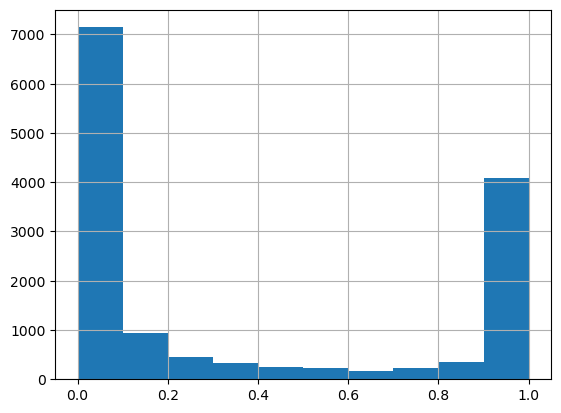

In [11]:
# change the name of the target present column to predictions
osfl_model_predictions = osfl_model_predictions.rename(columns={"target_present": "predicted"})
osfl_model_predictions.predicted.hist()

In [15]:
# prepend ../../ to the file paths stored in df.file
osfl_model_predictions.file = "../../" + osfl_model_predictions.file

In [17]:
osfl_model_predictions

,file,start_time,end_time,predicted
3093,../../data/processed/external_test_set_recordi...,459.0,462.0,0.999997
3112,../../data/processed/external_test_set_recordi...,487.5,490.5,0.999996
8885,../../data/processed/external_test_set_recordi...,175.5,178.5,0.999995
3020,../../data/processed/external_test_set_recordi...,349.5,352.5,0.999995
3167,../../data/processed/external_test_set_recordi...,570.0,573.0,0.999994
...,...,...,...,...
13629,../../data/processed/external_test_set_recordi...,123.0,126.0,0.000297
9255,../../data/processed/external_test_set_recordi...,133.5,136.5,0.000287
13619,../../data/processed/external_test_set_recordi...,108.0,111.0,0.000237
13630,../../data/processed/external_test_set_recordi...,124.5,127.5,0.000200


# The HawkEars model was run on the same data by using the analyze.py function in hawkears root. 
### This took 66 mins on the mac M1 CPU.
it would be faster if it ran on the GPU but this wasn't an option on the mac. 

# Load the hawkears preds

In [18]:
hawkears_files = glob.glob(str(data_path / "processed" / "hawkears"/"*.*"))

In [19]:
results = []
# Read and parse the hawkears file contents
for file_path in hawkears_files:
    with open(file_path, "r") as f:
        file_content = f.read().strip().split("\n")
        file_id = file_path.split("/")[-1].split("-")[1]
        file_id = file_id.split("_")[0]
        for detection in file_content:
            if detection:
                line = [file_id] + detection.split("\t")
            else:
                line = [file_id]
            results.append(line)
# Convert the results to a pandas DataFrame
df = pd.DataFrame(
    results, columns=["file_id", "start_time", "end_time", "species;confidence"]
)
df.file_id = df.file_id.astype(int)
df.sort_values(by=["file_id"], inplace=True)
df[["species", "confidence"]] = df["species;confidence"].str.split(";", expand=True)
df.drop(columns=["species;confidence"], inplace=True)
df = df.loc[df["species"] == "OSFL"]
df.confidence = df.confidence.astype(float)
hawkears_preds = df
hawkears_preds.rename(columns={"confidence":"hawkears_prediction"} , inplace=True)


In [20]:
hawkears_preds.head()

,file_id,start_time,end_time,species,hawkears_prediction
3815912,255412,255.00,258.00,OSFL,0.00
3815913,255412,256.50,259.50,OSFL,0.01
3815914,255412,258.00,261.00,OSFL,0.00
3815915,255412,259.50,262.50,OSFL,0.00
3815916,255412,261.00,264.00,OSFL,0.01


# Merge the data from OSFL.model and hawkears

In [21]:
osfl_model_predictions.set_index(["file", "start_time", "end_time"], inplace=True)

In [22]:
def get_rec_id_from_index(file_path):
    return file_path.split("/")[-1].split("-")[1].split(".")[0]
osfl_model_predictions['file_id'] = osfl_model_predictions.index.get_level_values('file').map(get_rec_id_from_index).astype(int)

In [23]:
osfl_model_predictions_reset = osfl_model_predictions.reset_index()

In [24]:
hawkears_preds.start_time = hawkears_preds.start_time.astype(float)
hawkears_preds.end_time = hawkears_preds.end_time.astype(float)
osfl_model_predictions_reset.start_time = osfl_model_predictions_reset.start_time.astype(float)
osfl_model_predictions_reset.end_time = osfl_model_predictions_reset.end_time.astype(float)
osfl_model_predictions_reset.file_id.astype(int)

0        255625
1        255625
2        255454
3        255625
4        255625
          ...  
14187    255421
14188    255949
14189    255421
14190    255421
14191    255421
Name: file_id, Length: 14192, dtype: int64

In [25]:
merged_df = pd.merge(osfl_model_predictions_reset, hawkears_preds, on=["file_id", "start_time", "end_time"],suffixes=('_df1', '_df2'))
merged_df

,file,start_time,end_time,predicted,file_id,species,hawkears_prediction
0,../../data/processed/external_test_set_recordi...,459.0,462.0,0.999997,255625,OSFL,0.98
1,../../data/processed/external_test_set_recordi...,487.5,490.5,0.999996,255625,OSFL,0.99
2,../../data/processed/external_test_set_recordi...,175.5,178.5,0.999995,255454,OSFL,0.86
3,../../data/processed/external_test_set_recordi...,349.5,352.5,0.999995,255625,OSFL,0.98
4,../../data/processed/external_test_set_recordi...,570.0,573.0,0.999994,255625,OSFL,0.98
...,...,...,...,...,...,...,...
14187,../../data/processed/external_test_set_recordi...,123.0,126.0,0.000297,255421,OSFL,0.01
14188,../../data/processed/external_test_set_recordi...,133.5,136.5,0.000287,255949,OSFL,0.01
14189,../../data/processed/external_test_set_recordi...,108.0,111.0,0.000237,255421,OSFL,0.01
14190,../../data/processed/external_test_set_recordi...,124.5,127.5,0.000200,255421,OSFL,0.01


<Axes: >

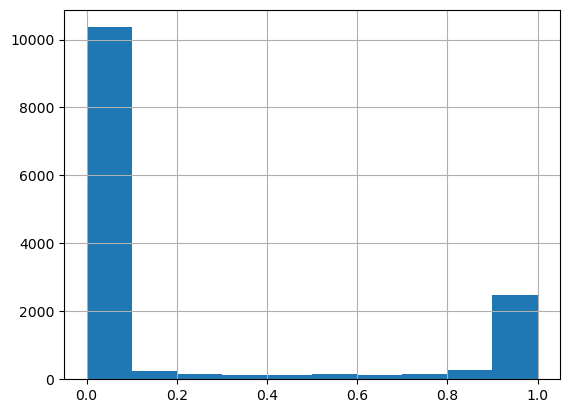

In [26]:
merged_df.hawkears_prediction.hist()

The amount of validation effort required to process these top scoring predictions for each model would take 30 hours based on an expected validation time of 5 hours per 1000 samples. 
There are 5000 + confident predictions made by the OSFL model which scored over 0.8, and there are 2500 found by HawkEars on the same data. 

To make the top down listening easier, we can take a sample of the recordings so that the listening work only takes a couple of hours. 

# Choose a sample of the recordings which isn't going to take too long to get through


In [27]:
merged_df.set_index(["file", "start_time", "end_time"], inplace=True)

<Axes: >

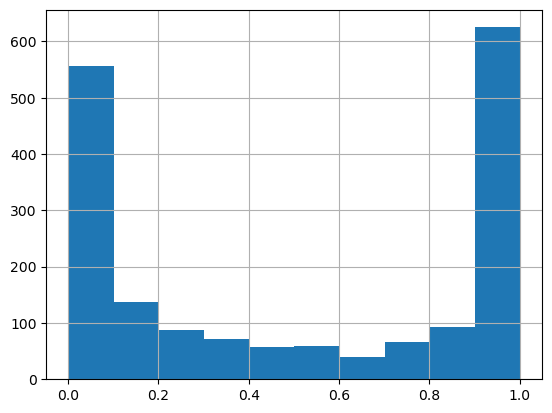

In [28]:
np.random.seed(42)
recordings = merged_df.index.get_level_values("file").unique()
sample = np.random.choice(recordings, 5)
sample_df = merged_df.loc[sample]
merged_df.loc[sample].predicted.hist()

# Top down listening
This process allows us to listen to the highest scoring predictions per model one by one and evaluate them as present or absent. 


## A label of 1 means Present
## A label of 2 means Absent

In [36]:
top_down_hawkears = sample_df[["hawkears_prediction"]]
top_down_hawkears.rename(columns={"hawkears_prediction":"predicted"}, inplace=True)
top_down_hawkears.sort_values(by="predicted", ascending=False, inplace=True)

top_down_osfl = sample_df[["predicted"]]
top_down_osfl.sort_values(by="predicted", ascending=False, inplace=True)

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_19771/791590438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_down_hawkears.rename(columns={"hawkears_prediction":"predicted"}, inplace=True)
/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_19771/791590438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_down_hawkears.sort_values(by="predicted", ascending=False, inplace=True)
/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_19771/791590438.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

('../../data/processed/external_test_set_recordings/recording-255449.mp3', 363.0, 366.0)
prediction = 0.28907904


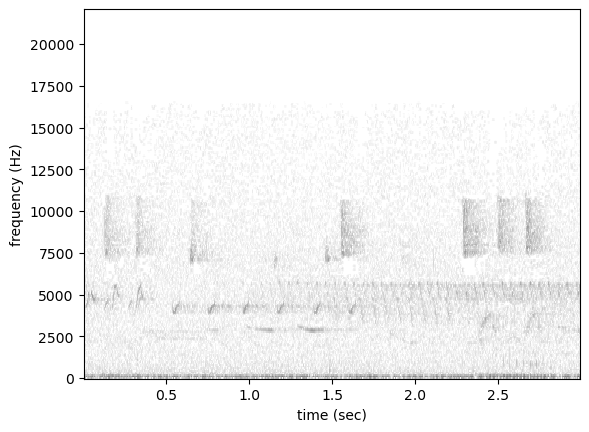

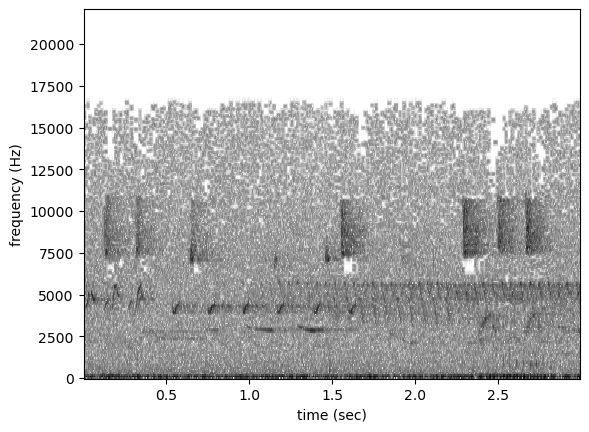

top down listening mode: press enter to autolabel as present or 2 for absent
added confidence tag 2 to the dataframe.
verification counts for all clips
confidence_cat
1    822
0    771
2    200
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:474: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


predicted  \
file                                               start_time end_time              
../../data/processed/external_test_set_recordin... 361.5      364.5      0.999953   
                                                   357.0      360.0      0.999923   
                                                   559.5      562.5      0.999879   
../../data/processed/external_test_set_recordin... 367.5      370.5      0.999863   
                                                   435.0      438.0      0.999784   
...                                                                           ...   
../../data/processed/external_test_set_recordin... 112.5      115.5      0.002052   
                                                   7.5        10.5       0.001869   
../../data/processed/external_test_set_recordin... 204.0      207.0      0.001797   
../../data/processed/external_test_set_recordin... 223.5      226.5      0.001672   
                                                   235.5      238.5      0.001638   

                                                                        confidence_cat  
file                                               start_time end_time                  
../../data/processed/external_test_set_recordin... 361.5      364.5                  1  
                                                   357.0      360.0                  1  
                                                   559.5      562.5                  1  
../../data/processed/external_test_set_recordin... 367.5      370.5                  1  
                                                   435.0      438.0                  1  
...                                                                                ...  
../../data/processed/external_test_set_recordin... 112.5      115.5                  0  
                                                   7.5        10.5                   0  
../../data/processed/external_test_set_recordin... 204.0      207.0                  0  
../../data/processed/external_test_set_recordin... 223.5      226.5                  0  
                                                   235.5      238.5                  0  

[1793 rows x 2 columns]

In [2151]:
top_down_listen(top_down_osfl)

In [564]:
top_down_osfl.to_pickle(data_path / "interim" / "top_down_osfl.pkl")


In [2304]:
top_down_hawkears.iloc[:500].confidence_cat.value_counts(), top_down_osfl.iloc[:500].confidence_cat.value_counts()  

(confidence_cat
 1    496
 2      4
 Name: count, dtype: int64,
 confidence_cat
 1    498
 2      2
 Name: count, dtype: int64)

The results are very similar at this stage - and most of the samples in the top 500 were of the olive sided flycatcher in both models. The 6 and 8 which were flagged as not OSFL could have contained an OSFL. 

# Check the next 500 predictions of each model

('../../data/processed/external_test_set_recordings/recording-255544.flac', 427.5, 430.5)
prediction = 0.295203


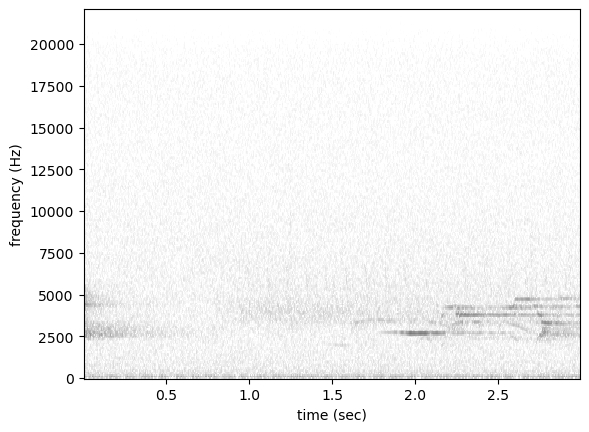

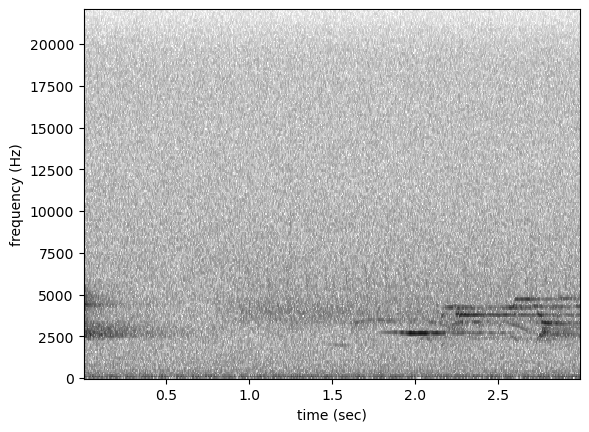

top down listening mode: press enter to autolabel as present or 2 for absent
added confidence tag 2 to the dataframe.
verification counts for all clips
confidence_cat
1    814
0    774
2    205
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:474: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


predicted  \
file                                               start_time end_time              
../../data/processed/external_test_set_recordin... 361.5      364.5      0.999953   
                                                   357.0      360.0      0.999923   
                                                   559.5      562.5      0.999879   
../../data/processed/external_test_set_recordin... 367.5      370.5      0.999863   
                                                   435.0      438.0      0.999784   
...                                                                           ...   
../../data/processed/external_test_set_recordin... 112.5      115.5      0.002052   
                                                   7.5        10.5       0.001869   
../../data/processed/external_test_set_recordin... 204.0      207.0      0.001797   
../../data/processed/external_test_set_recordin... 223.5      226.5      0.001672   
                                                   235.5      238.5      0.001638   

                                                                        confidence_cat  
file                                               start_time end_time                  
../../data/processed/external_test_set_recordin... 361.5      364.5                  1  
                                                   357.0      360.0                  1  
                                                   559.5      562.5                  1  
../../data/processed/external_test_set_recordin... 367.5      370.5                  1  
                                                   435.0      438.0                  1  
...                                                                                ...  
../../data/processed/external_test_set_recordin... 112.5      115.5                  0  
                                                   7.5        10.5                   0  
../../data/processed/external_test_set_recordin... 204.0      207.0                  0  
../../data/processed/external_test_set_recordin... 223.5      226.5                  0  
                                                   235.5      238.5                  0  

[1793 rows x 2 columns]

In [2097]:
top_down_listen(top_down_osfl)

In [2098]:
top_down_osfl.to_pickle(data_path / "interim" / "top_down_osfl.pkl")

('../../data/processed/external_test_set_recordings/recording-256035.mp3', 57.0, 60.0)
prediction = 0.01


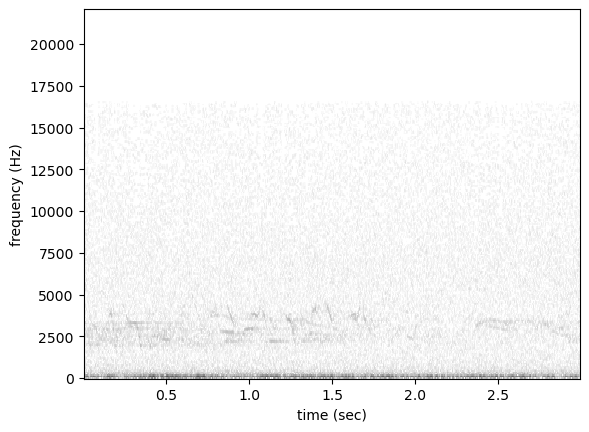

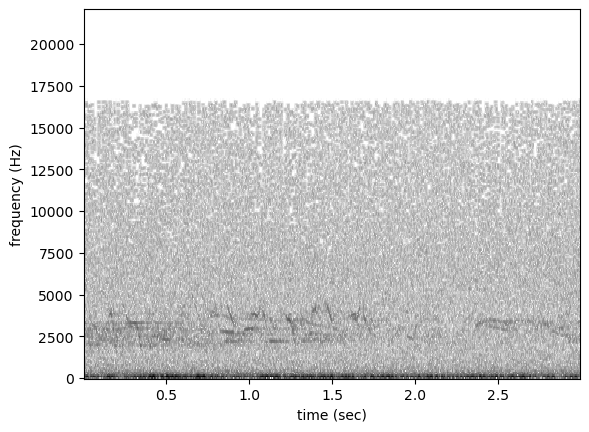

top down listening mode: press enter to autolabel as present or 2 for absent
added confidence tag 1 to the dataframe.
verification counts for all clips
confidence_cat
1    795
0    789
2    209
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:474: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


predicted  \
file                                               start_time end_time              
../../data/processed/external_test_set_recordin... 133.5      136.5          0.99   
../../data/processed/external_test_set_recordin... 243.0      246.0          0.99   
../../data/processed/external_test_set_recordin... 507.0      510.0          0.99   
                                                   568.5      571.5          0.99   
                                                   282.0      285.0          0.99   
...                                                                           ...   
../../data/processed/external_test_set_recordin... 208.5      211.5          0.00   
../../data/processed/external_test_set_recordin... 189.0      192.0          0.00   
                                                   292.5      295.5          0.00   
../../data/processed/external_test_set_recordin... 82.5       85.5           0.00   
../../data/processed/external_test_set_recordin... 10.5       13.5           0.00   

                                                                        confidence_cat  
file                                               start_time end_time                  
../../data/processed/external_test_set_recordin... 133.5      136.5                  1  
../../data/processed/external_test_set_recordin... 243.0      246.0                  1  
../../data/processed/external_test_set_recordin... 507.0      510.0                  1  
                                                   568.5      571.5                  1  
                                                   282.0      285.0                  1  
...                                                                                ...  
../../data/processed/external_test_set_recordin... 208.5      211.5                  0  
../../data/processed/external_test_set_recordin... 189.0      192.0                  0  
                                                   292.5      295.5                  0  
../../data/processed/external_test_set_recordin... 82.5       85.5                   0  
../../data/processed/external_test_set_recordin... 10.5       13.5                   0  

[1793 rows x 2 columns]

In [1865]:
top_down_listen(top_down_hawkears)

In [2099]:
top_down_hawkears.to_pickle(data_path / "interim" / "top_down_hawkears.pkl")

In [ ]:
# Check which labels didn't match and re-visit those examples
merged=pd.merge(top_down_osfl, top_down_hawkears, on=["file", "start_time", "end_time"],suffixes=('_osfl', '_hawkears'))

unmatched_index = merged.loc[merged.confidence_cat_osfl != 0].loc[merged.confidence_cat_hawkears != 0].loc[merged.confidence_cat_osfl != merged.confidence_cat_hawkears].index

top_down_osfl.loc[unmatched_index, "confidence_cat"] = 0
top_down_hawkears.loc[unmatched_index, "confidence_cat"] = 0


In [ ]:
top_down_listen(top_down_osfl)

In [ ]:
top_down_listen(top_down_hawkears)

In [ ]:
# Save the cleaned top-down listening data
top_down_hawkears.to_pickle(data_path / "interim" / "top_down_hawkears_cleaned.pkl")
top_down_osfl.to_pickle(data_path / "interim" / "top_down_osfl_cleaned.pkl")

# Load the cleaned top down data if it has already been done

In [2306]:
top_down_hawkears=pd.read_pickle(data_path / "interim" / "top_down_hawkears_cleaned.pkl")
top_down_osfl=pd.read_pickle(data_path / "interim" / "top_down_osfl_cleaned.pkl")

# We now have 1000 predictions in order of confidence from each model. 
- 99% of the top 500 were all OSFL calls. 


In [2314]:
top_down_osfl.iloc[:1000].confidence_cat.value_counts(), top_down_hawkears.iloc[:1000].confidence_cat.value_counts()

(confidence_cat
 1    817
 2    183
 Name: count, dtype: int64,
 confidence_cat
 1    790
 2    210
 Name: count, dtype: int64)

<Axes: xlabel='file,start_time,end_time'>

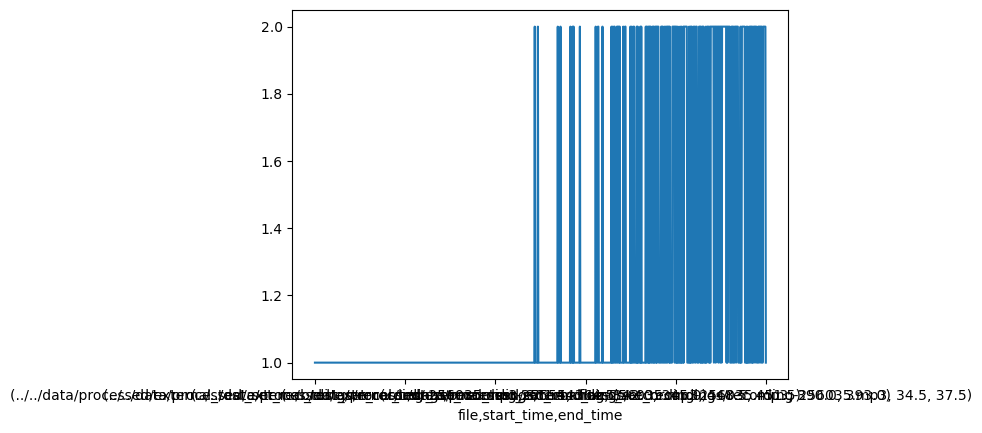

In [2317]:
top_down_osfl.iloc[:1000].confidence_cat.plot(xticks=None)


<Axes: xlabel='file,start_time,end_time'>

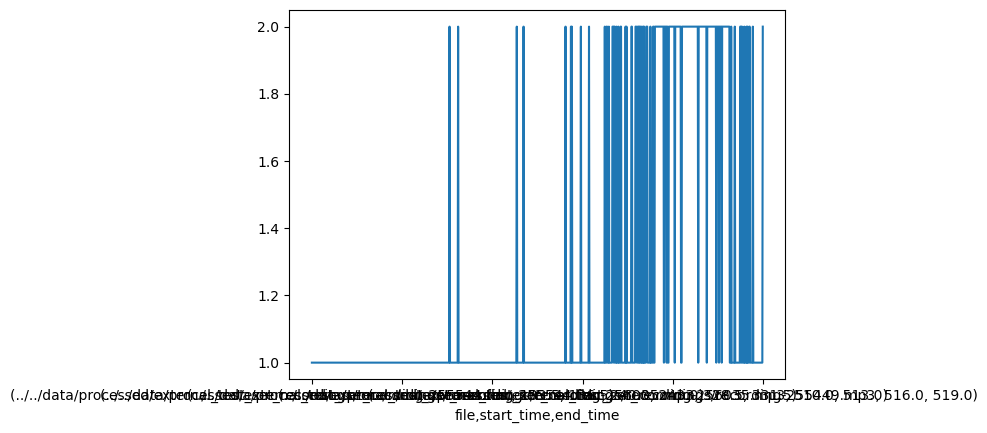

In [ ]:
top_down_hawkears.iloc[:1000].confidence_cat.plot()